<a href="https://colab.research.google.com/github/guoguolee88/Histopathologic-Cancer_Detection/blob/master/KAGGLE_CANCER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Histopathologic Cancer Detection

### Downloading the data

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

Navigate to the Kaggle website (https://www.kaggle.com/) in a web browser, log in, and go to the My Account page. In your account settings, you’ll find an API section. Clicking the Create New API Token button will generate a kaggle.json key file and will download it to your machine. Then go to your Colab notebook, and upload the API’s key JSON file to your Colab session by running the following code in a notebook cell:

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"guoguolee88","key":"c931391f8c40cda4b7597999022f29e2"}'}

you will see a Choose Files button appear. Click it and select the **kaggle.json** file you just downloaded. This uploads the file to the local Colab runtime.

In [3]:
!pip install -U -q kaggle
!mkdir ~/.kaggle # make directory 
!cp kaggle.json ~/.kaggle/ # copy the file
!chmod 600 ~/.kaggle/kaggle.json # change permissions on API key file make it only readable to yourself 

In [4]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.31G/6.31G [05:26<00:00, 22.0MB/s]
100% 6.31G/6.31G [05:26<00:00, 20.7MB/s]


In [5]:
!unzip -qq histopathologic-cancer-detection.zip


### Downloading necessary libraries

In [25]:
import numpy as np
import pandas as pd
from glob import glob
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution1D, concatenate, SpatialDropout1D, GlobalMaxPool1D, GlobalAvgPool1D, Embedding, \
    Conv2D, SeparableConv1D, Add, BatchNormalization, Activation, GlobalAveragePooling2D, LeakyReLU, Flatten
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, \
    Lambda, Multiply, LSTM, Bidirectional, PReLU, MaxPooling1D
#from keras.layers.pooling import _GlobalPooling1D
from keras.losses import mae, sparse_categorical_crossentropy, binary_crossentropy
from keras.models import Model
from keras.applications.nasnet import NASNetMobile, NASNetLarge, preprocess_input
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from imgaug import augmenters as iaa
import imgaug as ia

###Data visualization

**Quick look at the label stats**

In [7]:
data = pd.read_csv('/content/train_labels.csv')
train_path = '/content/train/'
test_path = '/content/test/'

In [8]:
data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [9]:
data.shape

(220025, 2)

In [10]:
count = data['label'].value_counts()
freq = data['label'].value_counts(normalize = True)
# freq = count/len(data)

y_freq = pd.DataFrame({'label': list(map(str, count.index)),
                       'count': count,
                       'freq': freq})

y_freq

,label,count,freq
0,0,130908,0.594969
1,1,89117,0.405031


We can see that the negative/positive ratio is not entirely 50/50 as there are 130k negatives and 90k negatives. The ratio is closer to 60/40 meaning that there are 1.5 times more negative images than positives.

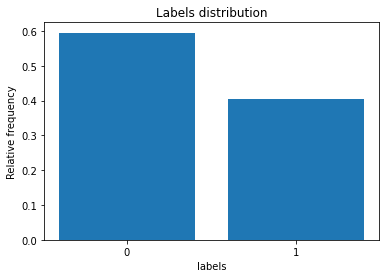

In [11]:
plt.subplot()
plt.bar(y_freq.loc[:, 'label'],
        y_freq.loc[:, 'freq'])
plt.xlabel('labels')
plt.ylabel('Relative frequency')
plt.title('Labels distribution')
plt.show()

**Plot some images with and without cancer tissue for comparison**

In [12]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img / 255

In [15]:
# random sampling
shuffled_data = shuffle(data)


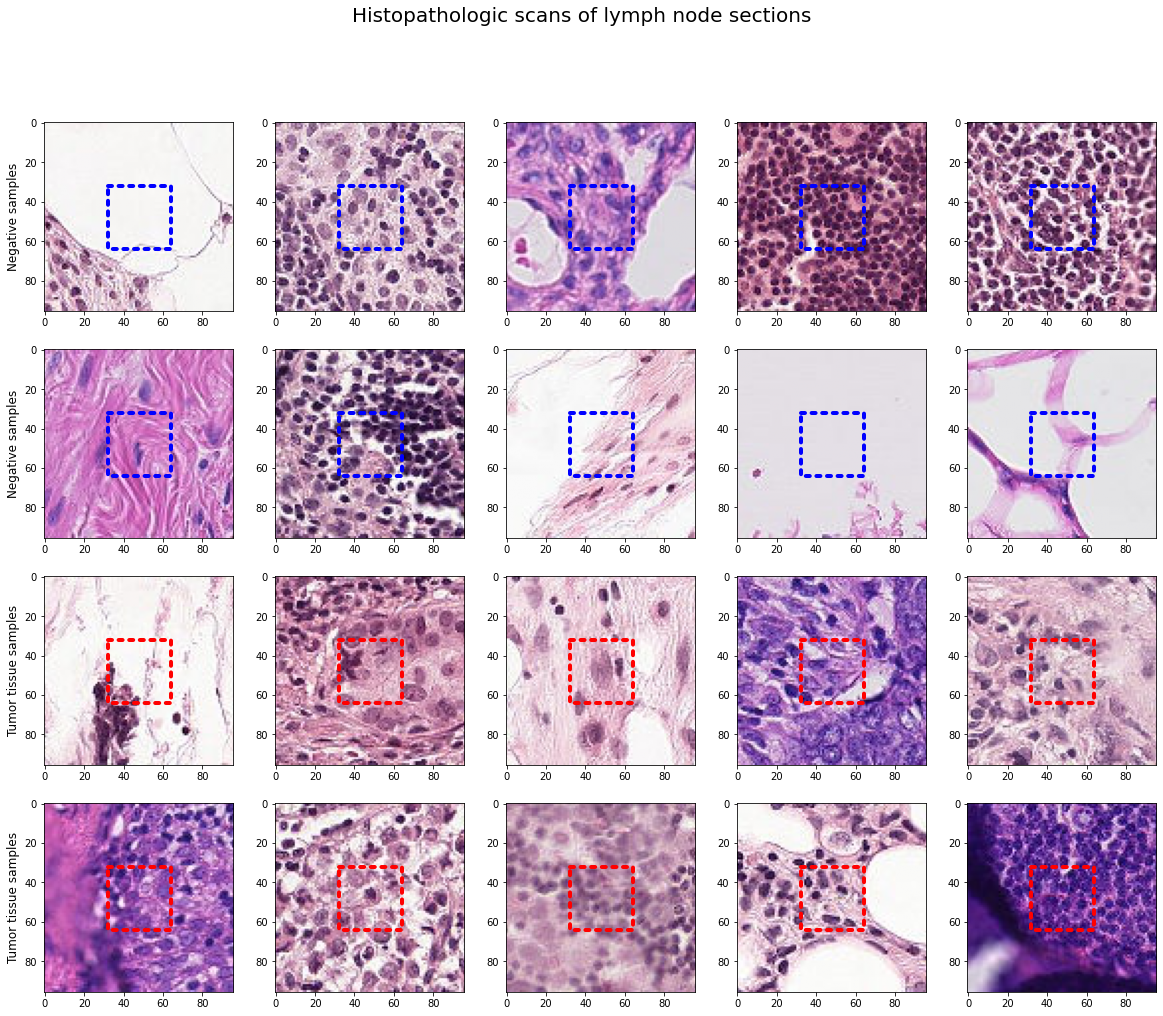

In [14]:
#fig, ax = plt.subplots(2,5, figsize=(20,8))
fig, ax = plt.subplots(4,5, figsize=(20,16))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)
# Negatives

for j in [0,1]:
    for i, idx in enumerate(data[data['label'] == 0]['id'][(j*5):((j+1)*5)]):
        path = os.path.join(train_path, idx)
        ax[j,i].imshow(readImage(path + '.tif'))
        # Create a Rectangle patch
        # box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='g',
        #                    facecolor='none', linestyle=':', capstyle='round')
        box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',
                            facecolor='none', linestyle=':', capstyle='round')
        ax[j,i].add_patch(box)
    ax[j,0].set_ylabel('Negative samples', size='large')

for j in [0,1]:
    # Positives
    for i, idx in enumerate(data[data['label'] == 1]['id'][(j*5):((j+1)*5)]):
        path = os.path.join(train_path, idx)
        ax[(j+2),i].imshow(readImage(path + '.tif'))
        # Create a Rectangle patch
        box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',
                            facecolor='none', linestyle=':', capstyle='round')
        ax[(j+2),i].add_patch(box)
    ax[(j+2),0].set_ylabel('Tumor tissue samples', size='large')

Classifying metastases is probably not an easy task for a trained pathologist and extremely difficult for an untrained eye. According to Libre Pathology, lymph node metastases can have these features:

Foreign cell population - key feature (Classic location: subcapsular sinuses)
Cells with cytologic features of malignancy
Nuclear pleomorphism (variation in size, shape and staining).
Nuclear atypia:
Nuclear enlargement.
Irregular nuclear membrane.
Irregular chromatin pattern, esp. asymmetry.
Large or irregular nucleolus.
Abundant mitotic figures.
Cells in architectural arrangements seen in malignancy; highly variable - dependent on tumour type and differentiation.
Gland formation.
Single cells.
Small clusters of cells.
The takeaway from this is probably that irregular nuclear shapes, sizes or staining shades can indicate metastases.

How is the data best transformed for modeling?
We know that the label of the image is influenced only by the center region (32 x 32px) so it would make sense to crop our data to that region only. However, some useful information about the surroundings could be lost if we crop too close. This hypothesis could be confirmed by training models with varying crop sizes. My initial results with 32 x 32px size showed worse performance than with 48 x 48px but I haven't done a search for optimal size.

How may we increase the data quality?
We could inspect if the data contains bad data (too unfocused or corrupted) and remove those to increase the overall quality.

**Preprocessing and augmentation - Self-Learning Purpose**


There are couple of ways we can use to avoid overfitting; more data, augmentation, regularization and less complex model architectures. Here we will define what image augmentations to use and add them directly to our image loader function. Note that if we apply augmentation here, augmentations will also be applied when we are predicting (inference). This is called test time augmentation (TTA) and it can improve our results if we run inference multiple times for each image and average out the predictions. The augmentations we can use for this type of data:

(not implemented here)

1.   random rotation
2.   random crop
3.   random flip (horizontal and vertical both)
4.   random lighting
5.   random zoom 
6.   Gaussian blur 

We will use OpenCV with image operations because OpenCV is a lot faster than PIL or scikit-image.

https://colab.research.google.com/github/guoguolee88/https-github.com-gsarti-cancer-detection/blob/master/densenet/densenet_kaggle.ipynb#scrollTo=699ptY7LsSez

### Loading Data

In [40]:
print(data.shape)

print(tr_n.shape)
print(len(tr_idx))

print(val_n.shape)
print(len(val_idx))


# print(tr_n)
# print(data.iloc[tr_idx,:])

# print(val_n)
# print(data.iloc[val_idx,:])

print(type(val_idx))

(220025, 2)
(198022,)
198022
(22003,)
22003
<class 'list'>


In [16]:
df_train = pd.read_csv("/content/train_labels.csv")
id_label_map = {k:v for k,v in zip(df_train.id.values, df_train.label.values)}
df_train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [17]:
def get_id_from_file_path(file_path):
    return file_path.split(os.path.sep)[-1].replace('.tif', '')

In [26]:
labeled_files = glob('/content/train/*.tif')
test_files = glob('/content/test/*.tif')

In [27]:
print("labeled_files size :", len(labeled_files))
print("test_files size :", len(test_files))

labeled_files size : 220025
test_files size : 57458


Text(0, 0.5, 'Tumor tissue samples')

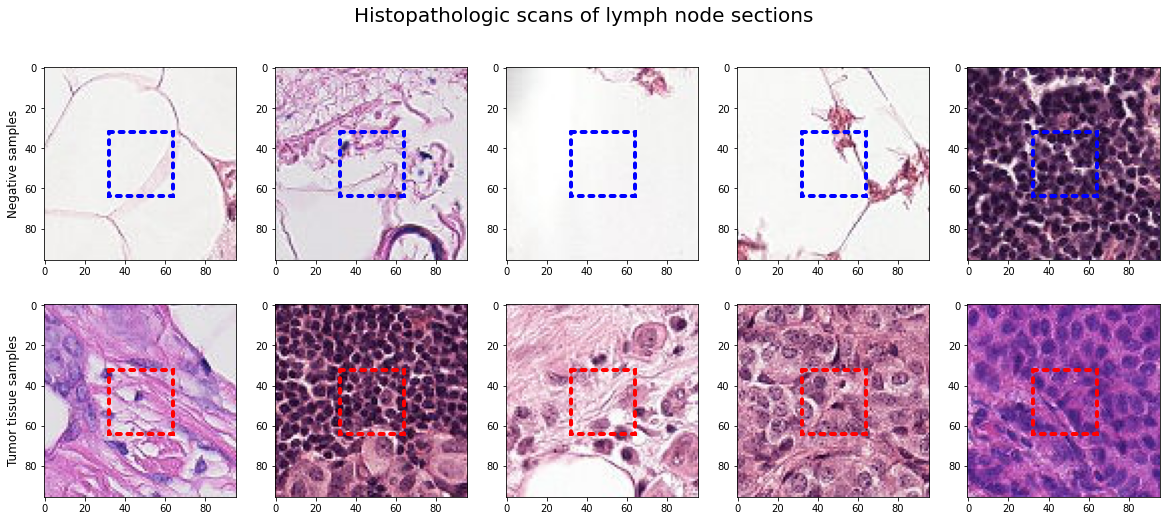

In [28]:
from sklearn.utils import shuffle

def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

# random sampling
shuffled_data = shuffle(df_train)

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

### Preprocessing

In this part, we define the train and validation split of the data, as well as the image augmentation which will take place during the training of the model. This is a necessary step for the model to be generalizable on future predictions.

In [33]:
train, val = train_test_split(labeled_files, test_size=0.1, random_state=101010)

In [30]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))
def get_seq():
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    seq = iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.Flipud(0.2), # vertically flip 20% of all images
            sometimes(iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
                rotate=(-10, 10), # rotate by -45 to +45 degrees
                shear=(-5, 5), # shear by -16 to +16 degrees
                order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
            )),
            # execute 0 to 5 of the following (less important) augmenters per image
            # don't execute all of them, as that would often be way too strong
            iaa.SomeOf((0, 5),
                [
                    sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 1.0)), # blur images with a sigma between 0 and 3.0
                        iaa.AverageBlur(k=(3, 5)), # blur image using local means with kernel sizes between 2 and 7
                        iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 2 and 7
                    ]),
                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)), # sharpen images
                    iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                    # search either for all edges or for directed edges,
                    # blend the result with the original image using a blobby mask
                    iaa.SimplexNoiseAlpha(iaa.OneOf([
                        iaa.EdgeDetect(alpha=(0.5, 1.0)),
                        iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                    ])),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.5), # add gaussian noise to images
                    iaa.OneOf([
                        iaa.Dropout((0.01, 0.05), per_channel=0.5), # randomly remove up to 10% of the pixels
                        iaa.CoarseDropout((0.01, 0.03), size_percent=(0.01, 0.02), per_channel=0.2),
                    ]),
                    iaa.Invert(0.01, per_channel=True), # invert color channels
                    iaa.Add((-2, 2), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                    iaa.AddToHueAndSaturation((-1, 1)), # change hue and saturation
                    # either change the brightness of the whole image (sometimes
                    # per channel) or change the brightness of subareas
                    iaa.OneOf([
                        iaa.Multiply((0.9, 1.1), per_channel=0.5),
                        iaa.FrequencyNoiseAlpha(
                            exponent=(-1, 0),
                            first=iaa.Multiply((0.9, 1.1), per_channel=True),
                            second=iaa.ContrastNormalization((0.9, 1.1))
                        )
                    ]),
                    sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                    sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                ],
                random_order=True
            )
        ],
        random_order=True
    )
    return seq

def data_gen(list_files, id_label_map, batch_size, augment=False):
    seq = get_seq()
    while True:
        shuffle(list_files)
        for batch in chunker(list_files, batch_size):
            X = [cv2.imread(x) for x in batch]
            Y = [id_label_map[get_id_from_file_path(x)] for x in batch]
            if augment:
                X = seq.augment_images(X)
            X = [preprocess_input(x) for x in X]
                
            yield np.array(X), np.array(Y)
    

### Defining the model

We define the architecture of the model, which is a NASNetMobile neural network, pre-trained on imagenet database, which we have found to work well with this dataset. In addition, we add a few other layers to obtain the final predictions. the pre-loaded weights will help us to get a headstart on this particular problem.

In [35]:


def get_model_classif_nasnet():
    inputs = Input((96, 96, 3))
    base_model = NASNetMobile(include_top=False, input_shape=(96, 96, 3))#, weights=None
    x = base_model(inputs)
    out1 = GlobalMaxPooling2D()(x)
    out2 = GlobalAveragePooling2D()(x)
    out3 = Flatten()(x)
    out = Concatenate(axis=-1)([out1, out2, out3])
    out = Dropout(0.5)(out)
    out = Dense(1, activation="sigmoid", name="3_")(out)
    model = Model(inputs, out)
    model.compile(optimizer=Adam(0.0001), loss=binary_crossentropy, metrics=['acc'])
    model.summary()

    return model
 

In [36]:
model = get_model_classif_nasnet()


ValueError: ignored

### Training the model


We proceed to train the model on the data while validating both the loss and the accuracy score in order to get a good idea on its performance. 

In [ ]:
batch_size=32
h5_path = "model.h5"
checkpoint = ModelCheckpoint(h5_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit_generator(
    data_gen(train, id_label_map, batch_size, augment=True),
    validation_data=data_gen(val, id_label_map, batch_size),
    epochs=2, verbose=1,
    callbacks=[checkpoint],
    steps_per_epoch=len(train) // batch_size,
    validation_steps=len(val) // batch_size)
batch_size=64
history = model.fit_generator(
    data_gen(train, id_label_map, batch_size, augment=True),
    validation_data=data_gen(val, id_label_map, batch_size),
    epochs=6, verbose=1,
    callbacks=[checkpoint],
    steps_per_epoch=len(train) // batch_size,
    validation_steps=len(val) // batch_size)


In [ ]:
batch_size=32
h5_path = "model.h5"
checkpoint = ModelCheckpoint(h5_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit_generator(
    data_gen(train, id_label_map, batch_size, augment=True),
    validation_data=data_gen(val, id_label_map, batch_size),
    epochs=2, verbose=1,
    callbacks=[checkpoint],
    steps_per_epoch=len(train) // batch_size,
    validation_steps=len(val) // batch_size)
batch_size=64
history = model.fit_generator(
    data_gen(train, id_label_map, batch_size, augment=True),
    validation_data=data_gen(val, id_label_map, batch_size),
    epochs=6, verbose=1,
    callbacks=[checkpoint],
    steps_per_epoch=len(train) // batch_size,
    validation_steps=len(val) // batch_size)


Epoch 1/2
6188/6188 [==============================] - 3509s 567ms/step - loss: 0.4096 - acc: 0.8146 - val_loss: 0.4131 - val_acc: 0.8068

Epoch 00001: val_loss improved from inf to 0.41314, saving model to model.h5
Epoch 2/2
6188/6188 [==============================] - 3367s 544ms/step - loss: 0.2982 - acc: 0.8722 - val_loss: 0.1840 - val_acc: 0.9295

Epoch 00002: val_loss improved from 0.41314 to 0.18396, saving model to model.h5
Epoch 1/6
3094/3094 [==============================] - 2557s 826ms/step - loss: 0.2481 - acc: 0.8967 - val_loss: 0.1596 - val_acc: 0.9402

Epoch 00001: val_loss improved from 0.18396 to 0.15960, saving model to model.h5
Epoch 2/6
3094/3094 [==============================] - 2644s 855ms/step - loss: 0.2341 - acc: 0.9026 - val_loss: 0.1567 - val_acc: 0.9388

Epoch 00002: val_loss improved from 0.15960 to 0.15673, saving model to model.h5
Epoch 3/6
3094/3094 [==============================] - 2586s 836ms/step - loss: 0.2234 - acc: 0.9076 - val_loss: 0.1877 - va

### Assessing performance

We finally load the best model (saved thanks to checkpoint on the validation loss metric), and assess the final performance thanks to AUC-ROC score and a confusion matrix, which will give us an idea on the sensivity and specifity of the model. 

In [ ]:
model.load_weights(h5_path)

In [ ]:
val_preds = []
val_ids = []

In [ ]:
for batch in chunker(val, batch_size):


In [ ]:
for batch in chunker(val, batch_size):
    X = [preprocess_input(cv2.imread(x)) for x in batch]
    ids_batch = [get_id_from_file_path(x) for x in batch]
    X = np.array(X)
    preds_batch = ((model.predict(X).ravel()*model.predict(X[:, ::-1, :, :]).ravel()*model.predict(X[:, ::-1, ::-1, :]).ravel()*model.predict(X[:, :, ::-1, :]).ravel())**0.25).tolist()
    val_preds += preds_batch
    val_ids += ids_batch

In [ ]:
val_preds_cat = (np.array(val_preds) > 0.5).astype(int)

In [ ]:
y_val = np.array([id_label_map[get_id_from_file_path(x)] for x in val])
print("Accuracy is: ", accuracy_score(y_val, val_preds_cat))
print("AUC_ROC score is: ", roc_auc_score(y_val, val_preds))

AUC_ROC score is:  0.952646416031849


In [48]:
df_cm = pd.DataFrame(confusion_matrix(y_val, val_preds_cat), index=["Predicted 0", "Predicted 1"], columns=["Actual 0", "Actual 1"])
sns.set(font_scale=1.0) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})

NameError: ignored